In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import zipfile
from sklearn.metrics import accuracy_score

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [2]:
# Function to unzip dataset
def unzip_dataset(zip_path, extract_path):
    print(f"Extracting {zip_path} to {extract_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")

# Unzip datasets (uncomment and run as needed)
unzip_dataset('Train.zip', './Train')
unzip_dataset('Test.zip', './Test')

Extracting Train.zip to ./Train...
Extraction complete!
Extracting Test.zip to ./Test...
Extraction complete!


In [3]:
# Define an improved Autoencoder for Denoising with skip connections (U-Net style)
class ImprovedAutoencoder(nn.Module):
    def __init__(self):
        super(ImprovedAutoencoder, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoding
        enc1_out = self.enc1(x)
        pool1_out = self.pool1(enc1_out)

        enc2_out = self.enc2(pool1_out)
        pool2_out = self.pool2(enc2_out)

        enc3_out = self.enc3(pool2_out)

        # Decoding with skip connections
        upconv2_out = self.upconv2(enc3_out)
        cat2 = torch.cat([upconv2_out, enc2_out], dim=1)
        dec2_out = self.dec2(cat2)

        upconv1_out = self.upconv1(dec2_out)
        cat1 = torch.cat([upconv1_out, enc1_out], dim=1)
        dec1_out = self.dec1(cat1)

        return dec1_out

In [4]:
# Custom Dataset for CUB-200
class CUB200Dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = []
        with open(annotations_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    self.img_labels.append((parts[0], int(parts[1])))
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(list(set([label for _, label in self.img_labels])))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels[idx][0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[idx][1]
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_num_classes(self):
        return len(set([label for _, label in self.img_labels]))

In [5]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((384, 384)),  # Increased to EfficientNet-B3's optimal input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(384, scale=(0.8, 1.0)),  # Additional augmentation
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
])


In [6]:
# Normalization will be applied after denoising
normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Function to denoise images
def denoise_images(autoencoder, images):
    with torch.no_grad():
        return autoencoder(images)

In [7]:
# Load train and test datasets
train_dataset = CUB200Dataset('train.txt', './Train/Train', train_transform)
test_dataset = CUB200Dataset('test.txt', './Test/Test', test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

num_classes = train_dataset.get_num_classes()
print(f"Number of classes: {num_classes}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of classes: 200
Number of training samples: 4829
Number of testing samples: 1204


In [8]:
# Initialize the improved autoencoder
autoencoder = ImprovedAutoencoder().to(device)

In [9]:
# Pretrain the autoencoder
def pretrain_autoencoder(autoencoder, train_loader, epochs=5):
    print("Pretraining autoencoder...")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in tqdm(train_loader):
            inputs = inputs.to(device)

            # Add noise to input images
            noise_factor = 0.2
            noisy_inputs = inputs + noise_factor * torch.randn_like(inputs)
            noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

            # Forward pass
            outputs = autoencoder(noisy_inputs)
            loss = criterion(outputs, inputs)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

    print("Autoencoder pretraining complete!")
    return autoencoder


In [10]:
# Calculate per-class accuracy
def calculate_class_accuracy(model, dataloader, autoencoder, num_classes):
    model.eval()
    autoencoder.eval()

    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Denoise and normalize
            inputs = denoise_images(autoencoder, inputs)
            inputs = torch.stack([normalize(img) for img in inputs])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Update class-wise accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (preds[i] == label).item()
                class_total[label] += 1

    # Calculate per-class accuracy
    per_class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            acc = class_correct[i] / class_total[i]
            per_class_acc.append(acc)

    avg_class_acc = sum(per_class_acc) / len(per_class_acc)
    return avg_class_acc

In [11]:
# Pretrain the autoencoder
autoencoder = pretrain_autoencoder(autoencoder, train_loader, epochs=5)

Pretraining autoencoder...


100%|██████████| 302/302 [05:30<00:00,  1.09s/it]


Epoch 1/5, Loss: 0.0047


100%|██████████| 302/302 [05:31<00:00,  1.10s/it]


Epoch 2/5, Loss: 0.0036


100%|██████████| 302/302 [05:31<00:00,  1.10s/it]


Epoch 3/5, Loss: 0.0034


100%|██████████| 302/302 [05:31<00:00,  1.10s/it]


Epoch 4/5, Loss: 0.0027


100%|██████████| 302/302 [05:31<00:00,  1.10s/it]

Epoch 5/5, Loss: 0.0025
Autoencoder pretraining complete!


In [12]:
# Load EfficientNet-B3
model = models.efficientnet_b3(weights='DEFAULT')
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 152MB/s]


In [13]:
# Initially freeze all layers of the backbone
for param in model.parameters():
    param.requires_grad = False

# Only enable training for the classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Training parameters
criterion = nn.CrossEntropyLoss()
max_epochs = 50
patience = 15  # For early stopping
best_acc = 0.0
epochs_no_improve = 0

train_acc_history = []
test_acc_history = []
avg_class_acc_history = []

In [14]:
# Training stages for gradual unfreezing
training_stages = [
    {'epochs': 10, 'unfreeze': None, 'lr': 0.001},            # Train only classifier
    {'epochs': 10, 'unfreeze': 'features.7', 'lr': 0.005},   # Unfreeze last feature block
    {'epochs': 10, 'unfreeze': 'features.6', 'lr': 0.0001},   # Unfreeze one more block
    {'epochs': max_epochs, 'unfreeze': 'features.5', 'lr': 0.0005}  # Unfreeze one more block
]

In [15]:
# Training function with gradual unfreezing
def train_with_unfreezing(model, autoencoder, training_stages, criterion):
    total_epoch = 0
    best_acc = 0.0
    epochs_no_improve = 0
    patience = 15
    train_acc_history = []
    test_acc_history = []
    avg_class_acc_history = []

    # Gradual unfreezing training loop
    for stage_idx, stage in enumerate(training_stages):
        print(f"\nTraining Stage {stage_idx+1}: LR={stage['lr']}")

        # Unfreeze specified layers
        if stage['unfreeze']:
            for name, param in model.named_parameters():
                if stage['unfreeze'] in name:
                    param.requires_grad = True
                    print(f"Unfreezing: {name}")

        # Setup optimizer and scheduler for this stage
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=stage['lr'])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=stage['epochs'])

        # Define max epochs for this stage
        stage_epochs = min(stage['epochs'], max_epochs - total_epoch)

        # Training loop for this stage
        for epoch in range(stage_epochs):
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {total_epoch} epochs!")
                break

            total_epoch += 1
            print(f'Epoch {total_epoch}/{max_epochs} (Stage {stage_idx+1})')
            print('-' * 10)

            # Training phase
            model.train()
            autoencoder.eval()  # Keep autoencoder in eval mode
            running_loss = 0.0
            y_true = []
            y_pred = []

            for inputs, labels in tqdm(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # Denoise and normalize
                inputs = denoise_images(autoencoder, inputs)
                inputs = torch.stack([normalize(img) for img in inputs])

                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

            # Calculate top-1 accuracy
            train_top1_acc = accuracy_score(y_true, y_pred)
            print(f'Train Loss: {running_loss/len(train_loader.dataset):.4f} Top-1 Acc: {train_top1_acc:.4f}')
            train_acc_history.append(train_top1_acc)

            # Evaluation phase
            model.eval()
            y_true = []
            y_pred = []

            with torch.no_grad():
                for inputs, labels in tqdm(test_loader):
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Denoise and normalize
                    inputs = denoise_images(autoencoder, inputs)
                    inputs = torch.stack([normalize(img) for img in inputs])

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            # Calculate top-1 and average class accuracy
            test_top1_acc = accuracy_score(y_true, y_pred)
            avg_class_acc = calculate_class_accuracy(model, test_loader, autoencoder, num_classes)

            print(f'Test Top-1 Acc: {test_top1_acc:.4f}, Avg Class Acc: {avg_class_acc:.4f}')
            test_acc_history.append(test_top1_acc)
            avg_class_acc_history.append(avg_class_acc)

            # Check for improvement
            if test_top1_acc > best_acc:
                best_acc = test_top1_acc
                epochs_no_improve = 0
                # Save best model
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'autoencoder_state_dict': autoencoder.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': total_epoch,
                    'best_acc': best_acc,
                }, 'best_model.pth')
                print(f"New best model saved with accuracy: {best_acc:.4f}")
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epochs")

            scheduler.step()

            # Early stopping check
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered!")
                break

    print(f"Training complete! Best accuracy: {best_acc:.4f}")
    return train_acc_history, test_acc_history, avg_class_acc_history, best_acc

# Start training with gradual unfreezing
train_acc_history, test_acc_history, avg_class_acc_history, best_acc = train_with_unfreezing(
    model, autoencoder, training_stages, criterion
)


Training Stage 1: LR=0.001
Epoch 1/50 (Stage 1)
----------


100%|██████████| 302/302 [02:24<00:00,  2.09it/s]


Train Loss: 4.6811 Top-1 Acc: 0.1127


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.2957, Avg Class Acc: 0.2831
New best model saved with accuracy: 0.2957
Epoch 2/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 3.3905 Top-1 Acc: 0.3435


100%|██████████| 76/76 [00:34<00:00,  2.21it/s]


Test Top-1 Acc: 0.3978, Avg Class Acc: 0.3850
New best model saved with accuracy: 0.3978
Epoch 3/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 2.7658 Top-1 Acc: 0.4719


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.4385, Avg Class Acc: 0.4256
New best model saved with accuracy: 0.4385
Epoch 4/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.11it/s]


Train Loss: 2.4004 Top-1 Acc: 0.5281


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.4601, Avg Class Acc: 0.4478
New best model saved with accuracy: 0.4601
Epoch 5/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.11it/s]


Train Loss: 2.1629 Top-1 Acc: 0.5680


100%|██████████| 76/76 [00:34<00:00,  2.18it/s]


Test Top-1 Acc: 0.4884, Avg Class Acc: 0.4799
New best model saved with accuracy: 0.4884
Epoch 6/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 1.9879 Top-1 Acc: 0.6188


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.5033, Avg Class Acc: 0.4956
New best model saved with accuracy: 0.5033
Epoch 7/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 1.8609 Top-1 Acc: 0.6424


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.4884, Avg Class Acc: 0.4786
No improvement for 1 epochs
Epoch 8/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 1.7998 Top-1 Acc: 0.6490


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.4983, Avg Class Acc: 0.4896
No improvement for 2 epochs
Epoch 9/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 1.7666 Top-1 Acc: 0.6571


100%|██████████| 76/76 [00:34<00:00,  2.18it/s]


Test Top-1 Acc: 0.5008, Avg Class Acc: 0.4919
No improvement for 3 epochs
Epoch 10/50 (Stage 1)
----------


100%|██████████| 302/302 [02:23<00:00,  2.10it/s]


Train Loss: 1.7382 Top-1 Acc: 0.6714


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.5141, Avg Class Acc: 0.5059
New best model saved with accuracy: 0.5141

Training Stage 2: LR=0.005
Unfreezing: features.7.0.block.0.0.weight
Unfreezing: features.7.0.block.0.1.weight
Unfreezing: features.7.0.block.0.1.bias
Unfreezing: features.7.0.block.1.0.weight
Unfreezing: features.7.0.block.1.1.weight
Unfreezing: features.7.0.block.1.1.bias
Unfreezing: features.7.0.block.2.fc1.weight
Unfreezing: features.7.0.block.2.fc1.bias
Unfreezing: features.7.0.block.2.fc2.weight
Unfreezing: features.7.0.block.2.fc2.bias
Unfreezing: features.7.0.block.3.0.weight
Unfreezing: features.7.0.block.3.1.weight
Unfreezing: features.7.0.block.3.1.bias
Unfreezing: features.7.1.block.0.0.weight
Unfreezing: features.7.1.block.0.1.weight
Unfreezing: features.7.1.block.0.1.bias
Unfreezing: features.7.1.block.1.0.weight
Unfreezing: features.7.1.block.1.1.weight
Unfreezing: features.7.1.block.1.1.bias
Unfreezing: features.7.1.block.2.fc1.weight
Unfreezing: features.7.1.block.2.fc1.bias
Unfre

100%|██████████| 302/302 [02:29<00:00,  2.02it/s]


Train Loss: 2.5031 Top-1 Acc: 0.3817


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.4801, Avg Class Acc: 0.4729
No improvement for 1 epochs
Epoch 12/50 (Stage 2)
----------


100%|██████████| 302/302 [02:29<00:00,  2.03it/s]


Train Loss: 1.5851 Top-1 Acc: 0.5713


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.5507, Avg Class Acc: 0.5473
New best model saved with accuracy: 0.5507
Epoch 13/50 (Stage 2)
----------


100%|██████████| 302/302 [02:29<00:00,  2.02it/s]


Train Loss: 1.1482 Top-1 Acc: 0.6788


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6038, Avg Class Acc: 0.5985
New best model saved with accuracy: 0.6038
Epoch 14/50 (Stage 2)
----------


100%|██████████| 302/302 [02:28<00:00,  2.03it/s]


Train Loss: 0.8397 Top-1 Acc: 0.7530


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6138, Avg Class Acc: 0.6054
New best model saved with accuracy: 0.6138
Epoch 15/50 (Stage 2)
----------


100%|██████████| 302/302 [02:29<00:00,  2.02it/s]


Train Loss: 0.5924 Top-1 Acc: 0.8223


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6362, Avg Class Acc: 0.6344
New best model saved with accuracy: 0.6362
Epoch 16/50 (Stage 2)
----------


100%|██████████| 302/302 [02:29<00:00,  2.03it/s]


Train Loss: 0.4402 Top-1 Acc: 0.8710


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6537, Avg Class Acc: 0.6484
New best model saved with accuracy: 0.6537
Epoch 17/50 (Stage 2)
----------


100%|██████████| 302/302 [02:28<00:00,  2.03it/s]


Train Loss: 0.2741 Top-1 Acc: 0.9151


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6694, Avg Class Acc: 0.6642
New best model saved with accuracy: 0.6694
Epoch 18/50 (Stage 2)
----------


100%|██████████| 302/302 [02:29<00:00,  2.03it/s]


Train Loss: 0.2230 Top-1 Acc: 0.9399


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6836, Avg Class Acc: 0.6778
New best model saved with accuracy: 0.6836
Epoch 19/50 (Stage 2)
----------


100%|██████████| 302/302 [02:28<00:00,  2.03it/s]


Train Loss: 0.1726 Top-1 Acc: 0.9534


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6952, Avg Class Acc: 0.6910
New best model saved with accuracy: 0.6952
Epoch 20/50 (Stage 2)
----------


100%|██████████| 302/302 [02:28<00:00,  2.03it/s]


Train Loss: 0.1450 Top-1 Acc: 0.9627


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7002, Avg Class Acc: 0.6958
New best model saved with accuracy: 0.7002

Training Stage 3: LR=0.0001
Unfreezing: features.6.0.block.0.0.weight
Unfreezing: features.6.0.block.0.1.weight
Unfreezing: features.6.0.block.0.1.bias
Unfreezing: features.6.0.block.1.0.weight
Unfreezing: features.6.0.block.1.1.weight
Unfreezing: features.6.0.block.1.1.bias
Unfreezing: features.6.0.block.2.fc1.weight
Unfreezing: features.6.0.block.2.fc1.bias
Unfreezing: features.6.0.block.2.fc2.weight
Unfreezing: features.6.0.block.2.fc2.bias
Unfreezing: features.6.0.block.3.0.weight
Unfreezing: features.6.0.block.3.1.weight
Unfreezing: features.6.0.block.3.1.bias
Unfreezing: features.6.1.block.0.0.weight
Unfreezing: features.6.1.block.0.1.weight
Unfreezing: features.6.1.block.0.1.bias
Unfreezing: features.6.1.block.1.0.weight
Unfreezing: features.6.1.block.1.1.weight
Unfreezing: features.6.1.block.1.1.bias
Unfreezing: features.6.1.block.2.fc1.weight
Unfreezing: features.6.1.block.2.fc1.bias
Unfr

100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.1387 Top-1 Acc: 0.9633


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7051, Avg Class Acc: 0.7011
New best model saved with accuracy: 0.7051
Epoch 22/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.1280 Top-1 Acc: 0.9642


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7110, Avg Class Acc: 0.7062
New best model saved with accuracy: 0.7110
Epoch 23/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.1042 Top-1 Acc: 0.9720


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.7043, Avg Class Acc: 0.7004
No improvement for 1 epochs
Epoch 24/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0992 Top-1 Acc: 0.9733


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7143, Avg Class Acc: 0.7094
New best model saved with accuracy: 0.7143
Epoch 25/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0826 Top-1 Acc: 0.9797


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7176, Avg Class Acc: 0.7108
New best model saved with accuracy: 0.7176
Epoch 26/50 (Stage 3)
----------


100%|██████████| 302/302 [02:40<00:00,  1.89it/s]


Train Loss: 0.0794 Top-1 Acc: 0.9816


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7184, Avg Class Acc: 0.7117
New best model saved with accuracy: 0.7184
Epoch 27/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0661 Top-1 Acc: 0.9855


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7193, Avg Class Acc: 0.7127
New best model saved with accuracy: 0.7193
Epoch 28/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0743 Top-1 Acc: 0.9812


100%|██████████| 76/76 [00:34<00:00,  2.18it/s]


Test Top-1 Acc: 0.7317, Avg Class Acc: 0.7260
New best model saved with accuracy: 0.7317
Epoch 29/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0660 Top-1 Acc: 0.9845


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7135, Avg Class Acc: 0.7078
No improvement for 1 epochs
Epoch 30/50 (Stage 3)
----------


100%|██████████| 302/302 [02:39<00:00,  1.89it/s]


Train Loss: 0.0699 Top-1 Acc: 0.9832


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.7085, Avg Class Acc: 0.7021
No improvement for 2 epochs

Training Stage 4: LR=0.0005
Unfreezing: features.5.0.block.0.0.weight
Unfreezing: features.5.0.block.0.1.weight
Unfreezing: features.5.0.block.0.1.bias
Unfreezing: features.5.0.block.1.0.weight
Unfreezing: features.5.0.block.1.1.weight
Unfreezing: features.5.0.block.1.1.bias
Unfreezing: features.5.0.block.2.fc1.weight
Unfreezing: features.5.0.block.2.fc1.bias
Unfreezing: features.5.0.block.2.fc2.weight
Unfreezing: features.5.0.block.2.fc2.bias
Unfreezing: features.5.0.block.3.0.weight
Unfreezing: features.5.0.block.3.1.weight
Unfreezing: features.5.0.block.3.1.bias
Unfreezing: features.5.1.block.0.0.weight
Unfreezing: features.5.1.block.0.1.weight
Unfreezing: features.5.1.block.0.1.bias
Unfreezing: features.5.1.block.1.0.weight
Unfreezing: features.5.1.block.1.1.weight
Unfreezing: features.5.1.block.1.1.bias
Unfreezing: features.5.1.block.2.fc1.weight
Unfreezing: features.5.1.block.2.fc1.bias
Unfreezing: feature

100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.2284 Top-1 Acc: 0.9331


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6752, Avg Class Acc: 0.6713
No improvement for 3 epochs
Epoch 32/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.1772 Top-1 Acc: 0.9474


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6927, Avg Class Acc: 0.6857
No improvement for 4 epochs
Epoch 33/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.1393 Top-1 Acc: 0.9619


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6827, Avg Class Acc: 0.6804
No improvement for 5 epochs
Epoch 34/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.1399 Top-1 Acc: 0.9588


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7010, Avg Class Acc: 0.6983
No improvement for 6 epochs
Epoch 35/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.73it/s]


Train Loss: 0.1187 Top-1 Acc: 0.9689


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6869, Avg Class Acc: 0.6796
No improvement for 7 epochs
Epoch 36/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.0929 Top-1 Acc: 0.9735


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6935, Avg Class Acc: 0.6886
No improvement for 8 epochs
Epoch 37/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.0832 Top-1 Acc: 0.9783


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.6985, Avg Class Acc: 0.6934
No improvement for 9 epochs
Epoch 38/50 (Stage 4)
----------


100%|██████████| 302/302 [02:54<00:00,  1.73it/s]


Train Loss: 0.0816 Top-1 Acc: 0.9793


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7093, Avg Class Acc: 0.7055
No improvement for 10 epochs
Epoch 39/50 (Stage 4)
----------


100%|██████████| 302/302 [02:54<00:00,  1.73it/s]


Train Loss: 0.0778 Top-1 Acc: 0.9791


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.6927, Avg Class Acc: 0.6868
No improvement for 11 epochs
Epoch 40/50 (Stage 4)
----------


100%|██████████| 302/302 [02:54<00:00,  1.73it/s]


Train Loss: 0.0658 Top-1 Acc: 0.9818


100%|██████████| 76/76 [00:34<00:00,  2.19it/s]


Test Top-1 Acc: 0.7193, Avg Class Acc: 0.7128
No improvement for 12 epochs
Epoch 41/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.0784 Top-1 Acc: 0.9803


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7068, Avg Class Acc: 0.7025
No improvement for 13 epochs
Epoch 42/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.0730 Top-1 Acc: 0.9816


100%|██████████| 76/76 [00:34<00:00,  2.20it/s]


Test Top-1 Acc: 0.7076, Avg Class Acc: 0.7040
No improvement for 14 epochs
Epoch 43/50 (Stage 4)
----------


100%|██████████| 302/302 [02:55<00:00,  1.72it/s]


Train Loss: 0.0679 Top-1 Acc: 0.9807


100%|██████████| 76/76 [00:34<00:00,  2.18it/s]

Test Top-1 Acc: 0.7143, Avg Class Acc: 0.7112
No improvement for 15 epochs
Early stopping triggered!
Training complete! Best accuracy: 0.7317


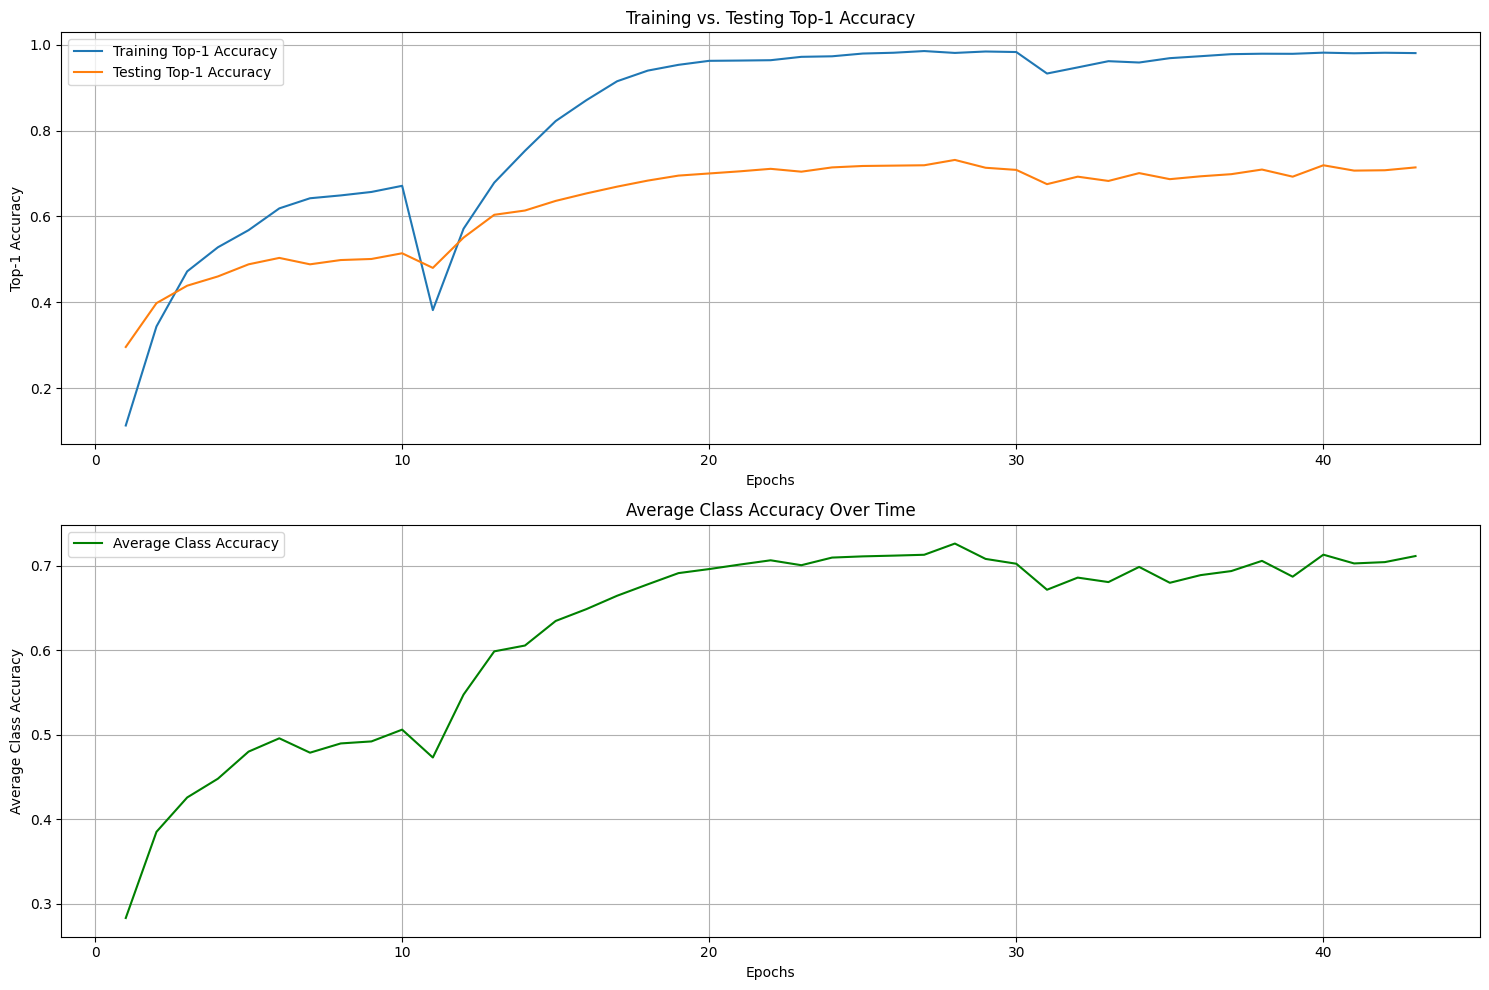

In [16]:
# Plot Results
def plot_results(train_acc_history, test_acc_history, avg_class_acc_history):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 1, 1)
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Training Top-1 Accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, label='Testing Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy')
    plt.title('Training vs. Testing Top-1 Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(avg_class_acc_history) + 1), avg_class_acc_history, label='Average Class Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Average Class Accuracy')
    plt.title('Average Class Accuracy Over Time')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('accuracy_plots.png')
    plt.show()

# Plot the results
plot_results(train_acc_history, test_acc_history, avg_class_acc_history)

In [17]:
# Load best model for final evaluation
def evaluate_best_model():
    # Load best model
    checkpoint = torch.load('best_model.pth')
    model = models.efficientnet_b3(weights='DEFAULT')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)

    autoencoder = ImprovedAutoencoder().to(device)
    autoencoder.load_state_dict(checkpoint['autoencoder_state_dict'])

    # Final evaluation
    model.eval()
    autoencoder.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Denoise and normalize
            inputs = denoise_images(autoencoder, inputs)
            inputs = torch.stack([normalize(img) for img in inputs])

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    final_top1_acc = accuracy_score(y_true, y_pred)
    final_avg_class_acc = calculate_class_accuracy(model, test_loader, autoencoder, num_classes)

    print(f"Final Results:")
    print(f"Top-1 Accuracy: {final_top1_acc:.4f}")
    print(f"Average Class Accuracy: {final_avg_class_acc:.4f}")

    return final_top1_acc, final_avg_class_acc


In [18]:
# Run final evaluation
final_top1_acc, final_avg_class_acc = evaluate_best_model()

<ipython-input-17-0d36d9244055>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')
100%|██████████| 76/76 [00:34<00:00,  2.19it/s]

Final Results:
Top-1 Accuracy: 0.7317
Average Class Accuracy: 0.7260
